In [1]:
# base
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm

# 可視化
import seaborn as sns
from statistics import mean 
import matplotlib.pyplot as plt

# ARIMA
import pmdarima as pm
from pmdarima import utils
from pmdarima import arima
from pmdarima import datasets
from pmdarima import model_selection

# GUI
import tkinter.filedialog

# 分析の戦略

1. 地球温暖化現象が叫ばれ始めたのが20世紀後半ということで、  
1990年代からのデータをもって以降の分析を進める(PreProcessにて抽出済み)
2. 月単位で時系列分析を進める  
3. 分析にあたっては、ARIMAモデルを利用  
データは、特に変数調整しない（Box-Coxなど）

# 前処理したデータの読み込み

In [2]:
# Dialogによるファイル選択
target_file = tkinter.filedialog.askopenfilename(filetypes=[("csvファイル", "*.csv")])

In [3]:
print(target_file)

D:/Project/kufu.ai-sama/data/analyze/target.csv


In [4]:
df = pd.read_csv(target_file)

# ARIMAモデルでトレンド成分や季節成分へ要素分解

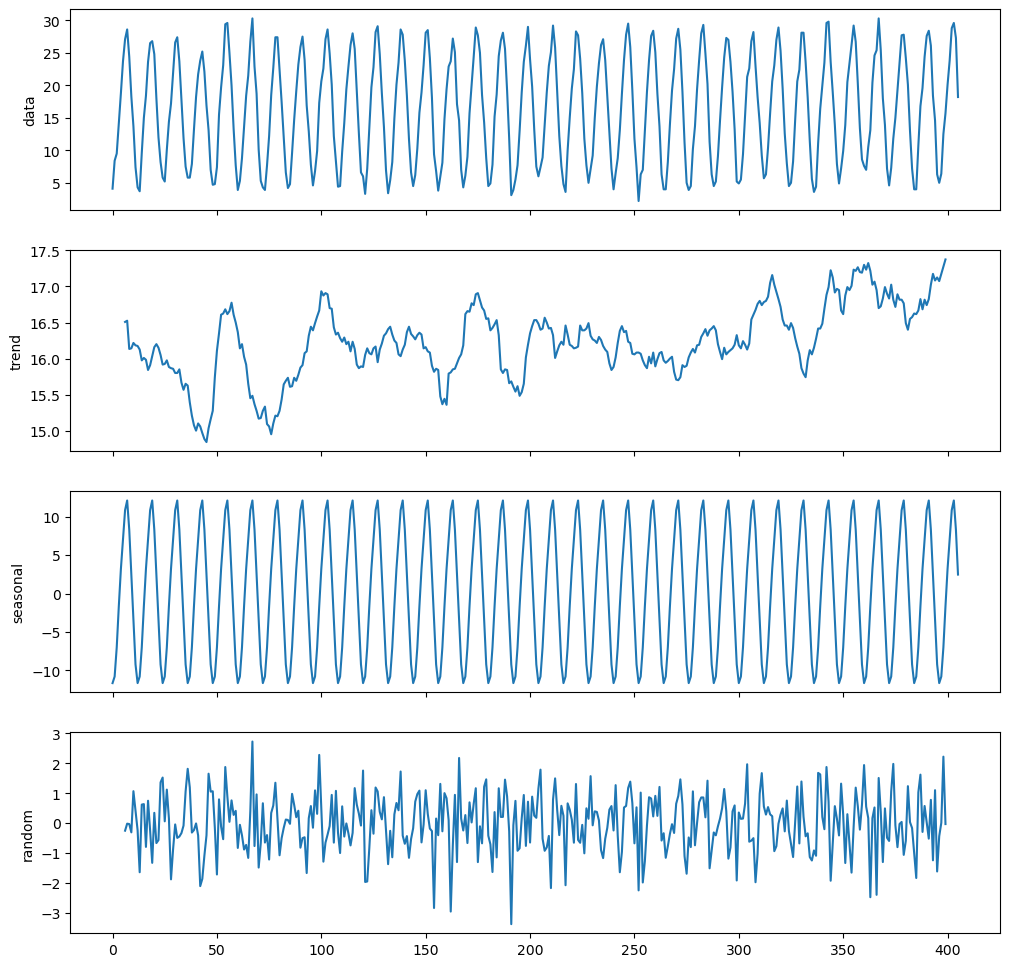

In [5]:
# ARIMAモデルで要素分析実施
utils.decomposed_plot(arima.decompose(df['average-temperature'], 'additive', m = 12),
                      figure_kwargs = {'figsize': (12, 12)} )

# 所見  
1. トレンドについて  
前処理で理解した通りに確認できた  
2. 季節性  
存在する模様

# 自己相関と偏自己相関の確認

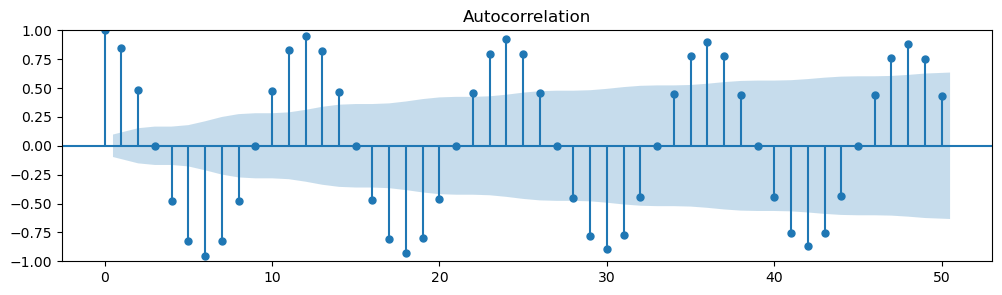

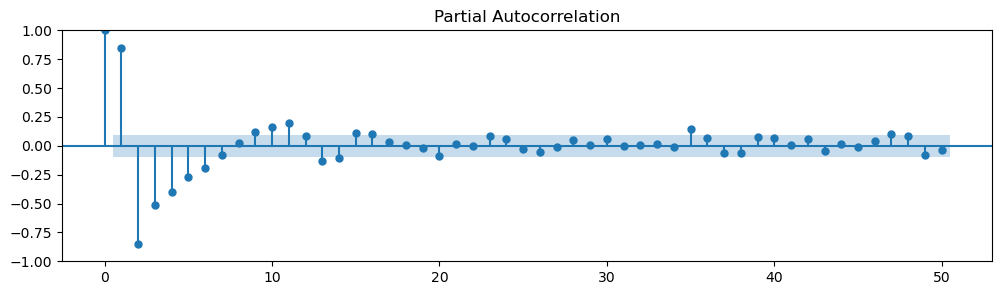

In [6]:
# グラフサイズ調整
plt.rcParams['figure.figsize'] = [12, 3]

# 自己相関と偏自己相関
fig = sm.graphics.tsa.plot_acf(df['average-temperature'], lags=50)
fig = sm.graphics.tsa.plot_pacf(df['average-temperature'], lags=50)

# 所見  
非定常データから定常データへの処置が必要

# 非定常データから定常データへ変換

In [7]:
print('d =', arima.ndiffs(df['average-temperature'])) #d（階差）
print('D =', arima.nsdiffs(df['average-temperature'],m=12)) #D（季節階差）

d = 0
D = 0


In [8]:
# 上記で、階差 0 / 季節階差 0 と判定された 
# 明らかにデータの成り立ちから乖離しているので、今後の分析においてはD = 1として扱う

In [9]:
# 階差、季節階差調整実施
data_d1_d12 = pd.DataFrame(df['average-temperature']).diff(1).diff(12).dropna()
len(data_d1_d12)

393

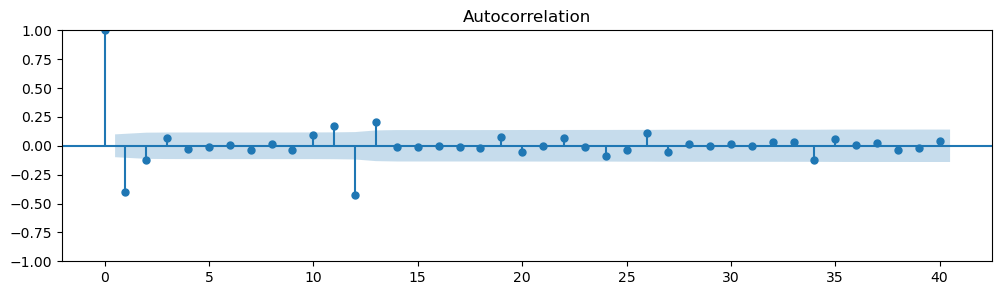

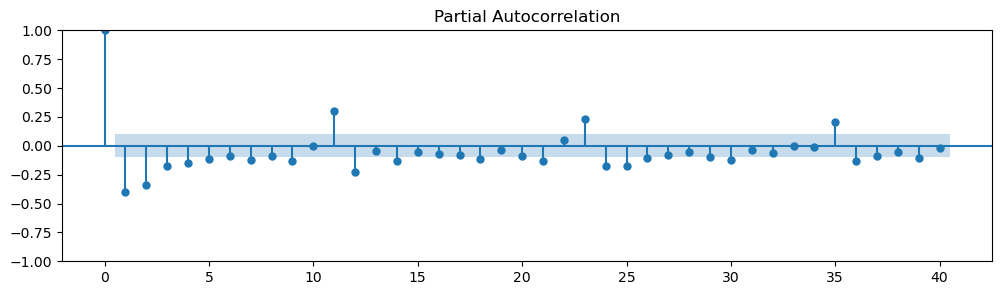

In [10]:
# グラフのサイズ調整
plt.rcParams['figure.figsize'] = [12, 3]
data_d1_d12.to_csv("hogehoge.csv")

# 自己相関と偏自己相関
fig = sm.graphics.tsa.plot_acf(data_d1_d12['average-temperature'],  lags=40)
fig = sm.graphics.tsa.plot_pacf(data_d1_d12['average-temperature'], lags=40)

# 所見

1. **Autocorrelation**  
周期性は軽減されたものの残る
2. **Partial Autocorrelation**  
周期性は軽減されたものの残る

完全には周期性を取り切れてはいない

# ARIMAモデル訓練

In [11]:
# データ分割（train:学習データ、test:テストデータ）
# Hold-Out法により、訓練・テストデータ分割
train, test = model_selection.train_test_split(df['average-temperature'], train_size=int(len(df) * 0.80))
print("total:"+str(len(df)))
print("train:"+str(len(train)))
print("test:" +str(len(test)))

total:406
train:324
test:82


In [12]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, 
                            seasonal=True,
                            m=12,
                            d=1,
                            D=1,
                            trace=True,
                            n_jobs=1,
                            maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1257.721, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1142.959, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1199.948, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1090.364, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1149.465, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1076.164, Time=0.18 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1119.360, Time=0.09 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1072.710, Time=0.21 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1114.3

# モデルの適合性判定

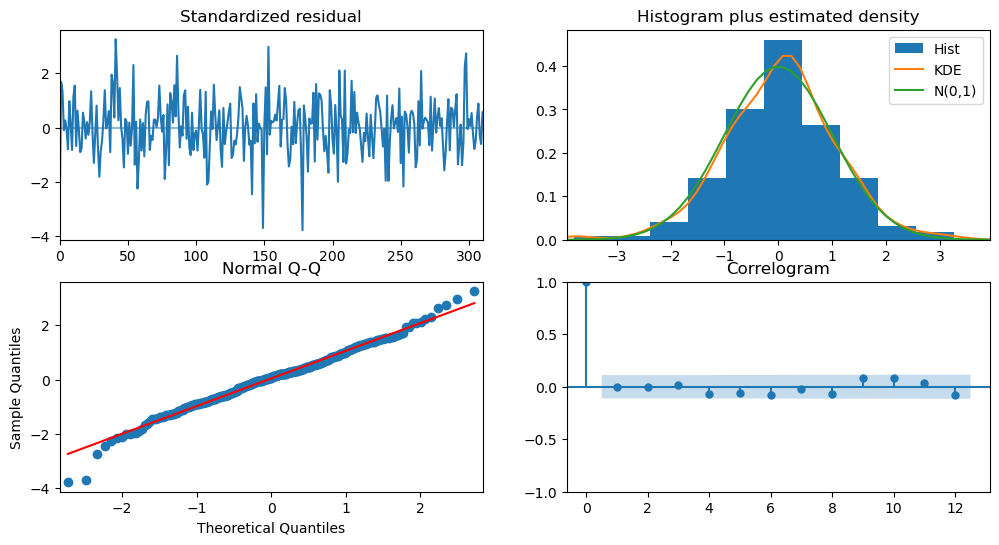

In [13]:
plt.rcParams['figure.figsize'] = [12, 6]
arima_model.plot_diagnostics(lags=12);

# 所見  

1. Standardized Residual(標準化残差プロット)   
モデルの残差を標準化したものを時系列表示  
**期待**：残差がトレンド、周期性なくランダムにばらついていることを期待  
**判断**：トレンド、周期性はなさそう  
  
2. Histogram plus estimated density(ヒストグラムと推定密度プロット)  
残差のヒストグラムとカーネル密度推定を表示  
**期待**：ヒストグラムと密度推定の形状が正規分布に近い形になることを期待  
**判断**：おおむね正規分布に沿っている  
  
3. Normal Q-Q (Quantile-Quantile) Plot (正規Q-Qプロット)  
残差の分位数を正規分布の分位数と比較したもの  
**期待**：プロットされた点は対角線に近い位置に分布していることを期待  
**判断**：おおむね期待に沿っている  
  
4. Correlogram (自己相関プロット)  
残差の自己相関係数をタイムラグに対して表示  
**期待**：自己相関プロットはほとんどのラグでゼロに近くなることを期待  
**判断**：おおむね期待に沿っている

# テストデータに対しての予測精度検証

82
MAE:
1.1665817486376624
MAPE(%):
11.753110665658827


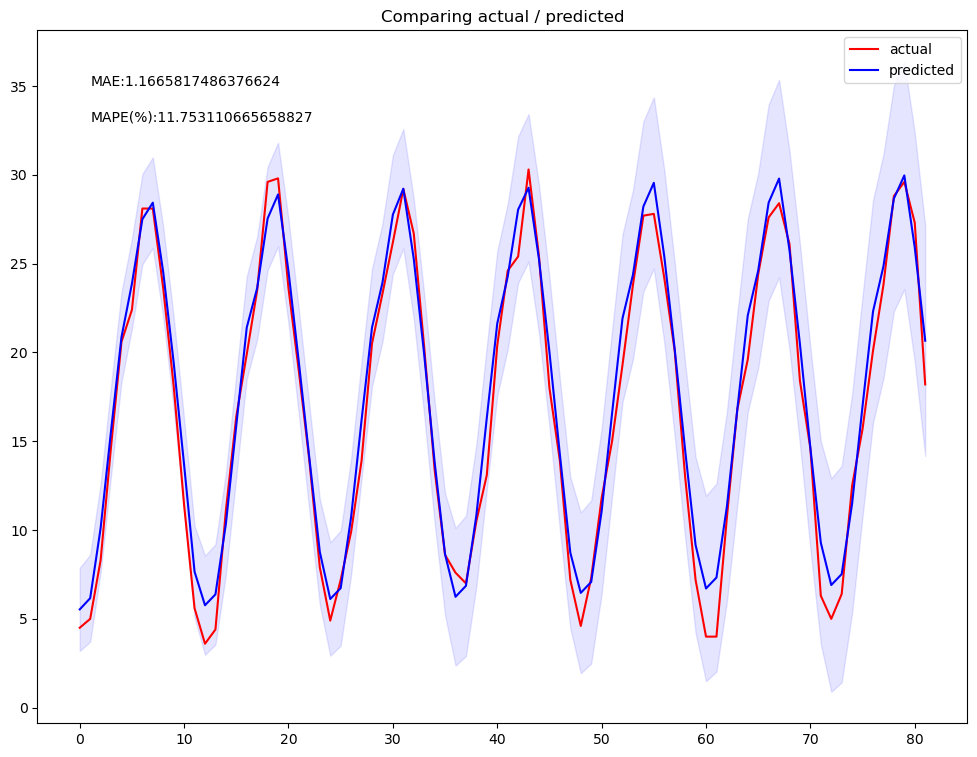

In [14]:
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [12, 9]

# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], return_conf_int=True)
print(test.shape[0])

# 予測精度
print('MAE:')
print(mean_absolute_error(test, preds)) 
print('MAPE(%):')
print(np.mean(np.abs(test - preds)/test)*100)

# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])

plt.title('Comparing actual / predicted')
plt.plot(x_axis, test, label="actual",color='r') 
plt.plot(x_axis, preds,label="predicted",color='b')
plt.fill_between(x_axis[-preds.shape[0]:],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')

plt.text(1,35, 'MAE:'+str(mean_absolute_error(test, preds)))
plt.text(1,33, 'MAPE(%):'+str(np.mean(np.abs(test - preds)/test)*100))

plt.legend()

# 所見

MAE / MAPE(%)ともに未チューニングの状態で、まずまずの結果

# 2030年 / 2050年の予測 （2022年と比較する形で表示）

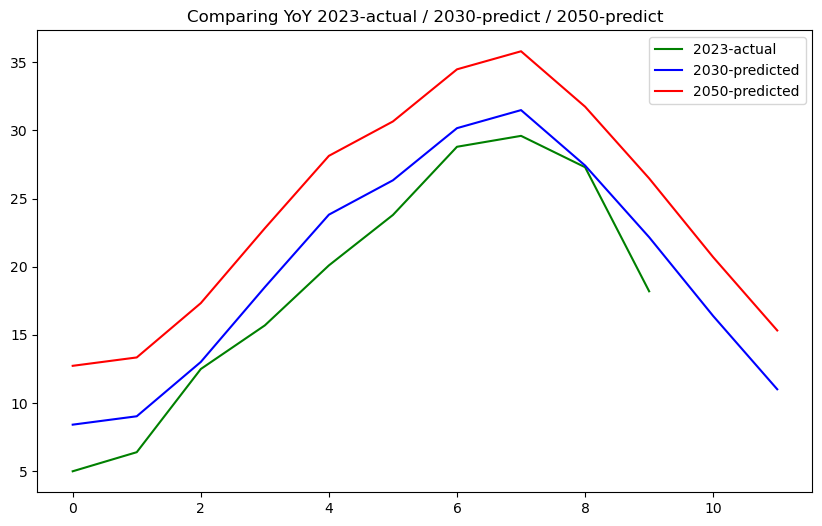

In [16]:
# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [10, 6]

plt.title('Comparing YoY 2023-actual / 2030-predict / 2050-predict')

# 実データ 2023年データ
actual_df_2023 = df.loc[396:405]
x_axis = np.arange(actual_df_2023['average-temperature'].shape[0])
plt.plot(x_axis, actual_df_2023['average-temperature'],label="2023-actual",color='g')

plt.legend()

# 予測
# 2023年11月から2050年12月まで予測実施
preds, conf_int = arima_model.predict(n_periods=408, return_conf_int=True)

preds_df = pd.DataFrame(preds, columns=['pred-temperature'])

# 2030年の予測を取得
preds_df_2030 = preds_df.loc[480:491]

# 予測グラフ
x_axis = np.arange(preds_df_2030['pred-temperature'].shape[0])
plt.plot(x_axis,preds_df_2030['pred-temperature'],label="2030-predicted",color='b')
plt.legend()

# 2050年の予測を取得
preds_df_2050 = preds_df.loc[720:731]

# 予測グラフ
x_axis = np.arange(preds_df_2050['pred-temperature'].shape[0])
plt.plot(x_axis,preds_df_2050['pred-temperature'],label="2050-predicted",color='r')
plt.legend()

# 所見

2023年と比較して、2030年、2050年ともに気温上昇している様子が見られる  

地域限定ではあるものの 過去、未来ともに安定した分析結果を得られると見込んだ**内陸部**の岐阜について  
気温上昇傾向があると云うことができ、地球温暖化が日本でも進んでいることの一つの証左となりえると判断  

より包括的な調査をするのであれば、地域、地点を慎重に選択しつつ本試行でのプロセスを踏むのも手立てだと推察する

  
## 精度向上にあたって  
1. SARIMAの試行
2. パラメータチューニング

## 改善点、今後の発展について  

下記の点で改善、発展が考えられる

### 改善

1. https://www.data.jma.go.jp/gmd/risk/obsdl/index.php よりダウンロードしたデータの自動整形  
    1. ヘッダの整形
    2. 文字コード変換(shift-jis -> UTF8)  

2. 本Notebookセル16での2030/2050年周期指定をスマートに  

3. スクレイピングによるデータ自動取得の実現

### 発展
1. **階層ベイズによる分析**が包括的な分析スタイルだと考えている  
都市化の要素、沿岸部の要素、熱帯性の気候への対応といった諸元に対してもベイズアプローチで対応可能なのでは？
と考える